In [2]:
import pandas as pd
import numpy as np
import json
import statistics
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import svm, tree, ensemble
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
import pickle

In [3]:
with open('dtype_dict_EDA.json', 'r') as file:
    dtype_dict = json.load(file)


parse_dates = [key for key, value in dtype_dict.items() if value ==
               'datetime64[ns]']
other_dtypes = {key: value for key,
                value in dtype_dict.items() if value != 'datetime64[ns]'}

for key in other_dtypes:
    if other_dtypes[key] == 'category':
        other_dtypes[key] = 'category'
    else:
        other_dtypes[key] = pd.api.types.pandas_dtype(other_dtypes[key])

df = pd.read_csv("final_data_EDA.csv", dtype=other_dtypes, parse_dates=parse_dates)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

There is a public avaiable dataset for different Municipalities in Sweden (https://www.scb.se/en/finding-statistics/statistics-by-subject-area/population/population-composition/population-statistics/pong/tables-and-graphs/population-statistics---year/population-in-the-country-counties-and-municipalities-on-31-december-2022-and-population-change-in-2022/)

We shall try to merge this with our dataset 

In [4]:
df_population = pd.read_csv("population_size.csv")

In [5]:
df_population = df_population.iloc[:, 1:3]

df_population.columns = ["Municipality","Population_size"]

df_population["Population_size"] = df_population["Population_size"].str.replace(",", "")
df_population["Population_size"] = df_population["Population_size"].astype(int)
df_population["Municipality"] = df_population["Municipality"].str.strip()

In [6]:
a = pd.merge(df, df_population, on='Municipality', how='left')


a["Population_size"].isna().sum()
#df.Municipality.map(df_population.set_index("Municipality")["Population_size"])

#pd.reset_option('display.max_rows')

1226

Upon merging we noticed a huge number of Na values which is a lot compared to the total dataset. And upon further analysis, the reason for this is the difference in spelling from our dataset and the public dataset. (Spelling names in English is different than in Sweden). So we shall not include this population size attribute even though it would have been valuable for our model. 

We shall remove the columns that we know doesnt add value to the predictor variable like "House_Name", "Price_Change" etc. and also redundant variables that we found during the EDA phase. 

Additionally, the number of categories that we see in the "location" column is more than 1300 levels and our dataset is only 2100, given that we also have the "Municipality" column which is superset of the "Location" column, the variance of the "Location" can be captured by "Municipality" so we can remove the "Location" column. 

In [7]:
del df["House_Name"]
del df["Price_Change"]
del df["Sold_date"]
del df["Charge"]
del df["Operating_cost"]
del df["Release_form"]
del df["Location"]
del df["Total_no_Floors"]
del df["Starting_price"]

df = df.dropna(subset=['Municipality'])

df["Lift"] = df["Lift"].map({'No': 0, 'Yes': 1})

df["Balcony"] = df["Balcony"].map({'No': 0, 'Yes': 1})

We shall now do one-hot encoding for some of the catergorial variables, since we want to try using Linear regression and SVM as well. 

In [8]:
df = pd.get_dummies(df, columns=['Built_on'], dtype='int')
df = pd.get_dummies(df, columns=['House_type'], dtype='int')

Now, we need to handle the "Municipality" column which has 229 levels, just doing one-hot encoding for this can lead to the curse of dimensionality, so some kind of dimensionality reduction will need to be done after that. We shall explore some strategies like label encoding,target encoding hashing, weight-of-evidence or entity embedding. Do this case, we shall use target encoding.  

But first we need to split the data into train and test to avoid leakage. 

Splitting the data into Train and test (60 - 40). We shall do CV using part of the test set which we shall do going forward.

In [9]:
X = df.drop(columns=["Final_Price"])
y = df["Final_Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
def target_encode(X, y):
    encoded_dict = X.groupby(X).apply(
        lambda x: y.loc[x.index].mean()).to_dict()
    return X.map(encoded_dict), encoded_dict


encoded_train, encoding_dict = target_encode(X_train["Municipality"], y_train)

warnings.filterwarnings('ignore')

def apply_encoding(X, encoding_dict, default_value=None):
    return X.map(encoding_dict).fillna(default_value)


default_value = y_train.mean()  
encoded_test = apply_encoding(
    X_test["Municipality"], encoding_dict, default_value)


X_train["Municipality"]= encoded_train

X_test["Municipality"] = encoded_test

/var/folders/d7/ssk2m93d5p52f37_qf9hg_k80000gn/T/ipykernel_96637/1802902914.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  encoded_dict = X.groupby(X).apply(


We start by using a linear regression model. We shall use MSE, MAE and R^2 as metrics to compare different models. 

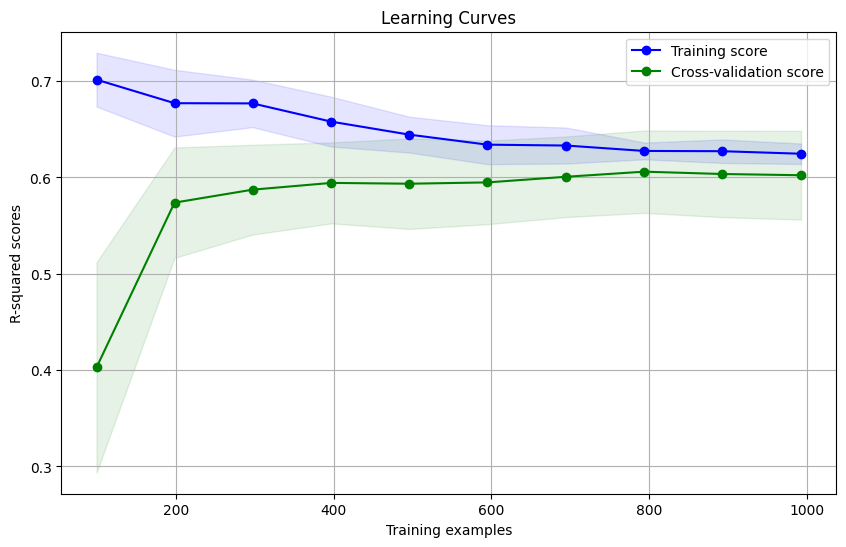

In [11]:
model1 = LinearRegression()

def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
        scoring='r2', shuffle=True, random_state=1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("R-squared scores")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


plot_learning_curves(model1, X_train, y_train)

We see that the performance for the validation improving and around the same range as training, so we dont see any overfitting. 

In [12]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.3322295986939192
Mean Squared Error: 5.147485700951214
R-squared: 0.33325585809932645


We see that the R^2 value is 33% which says that 33% of the variance of the dependent variable can be explained by the independent variables which isnt a lot.

Modelling SVM for the data

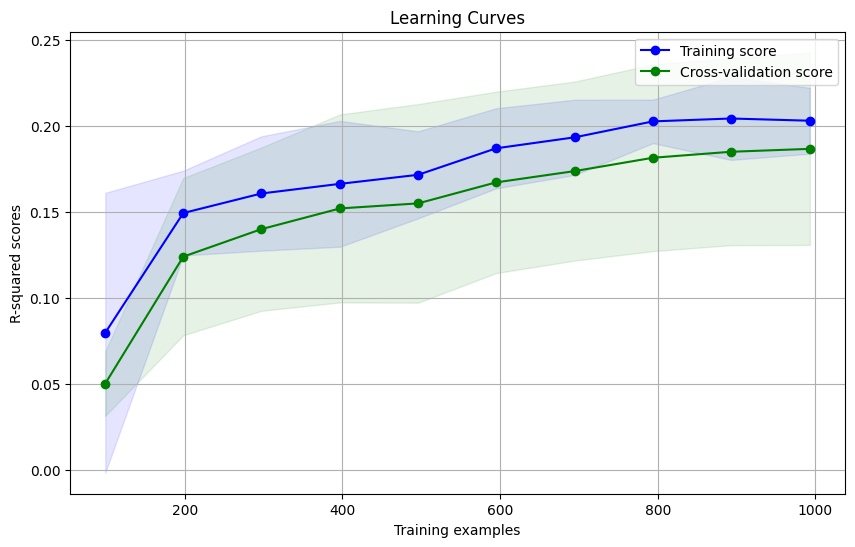

In [13]:
model2 = svm.SVR()

plot_learning_curves(model2, X_train, y_train)

Based on the above graph, SVM isnt a good fit for the data. 

In [14]:
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.585232087001039
Mean Squared Error: 6.521854463149802
R-squared: 0.15523645712501122


Modeling a Decision tree for the data

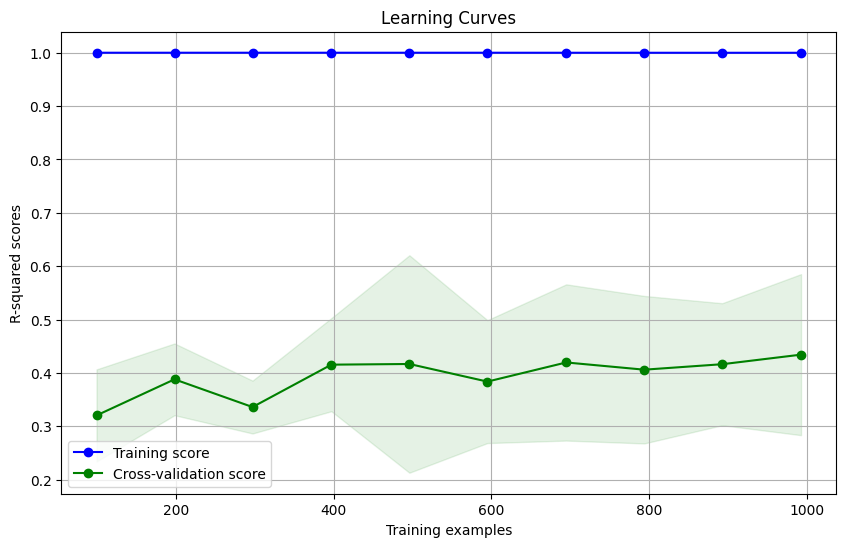

In [15]:
model3 = tree.DecisionTreeRegressor()

plot_learning_curves(model3, X_train, y_train)

From the above, we notice that the tree clearly overfits. Lets explore the tree structure

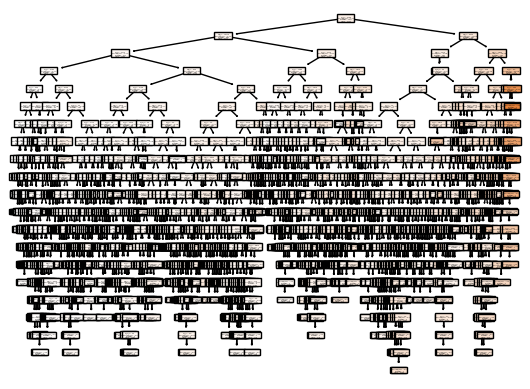

In [16]:
model3.fit(X_train, y_train)

model3.tree_.max_depth

plot_tree(model3, filled=True)
plt.show()

We should prune the tree to see if we can generalize the model to reduce overfitting. The above tree has a max depth of 24, lets reduce it to 6. 

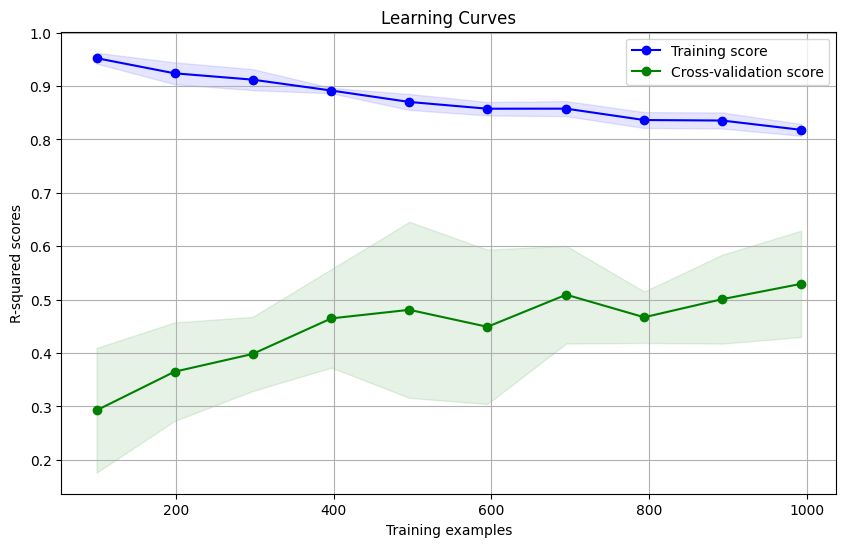

In [17]:
model4 = tree.DecisionTreeRegressor(max_depth=6)
plot_learning_curves(model4, X_train, y_train)

The model seems to overfit less now as the number of training examples increases. We see that the R^2 score for the test data has improved too as shown below  

In [18]:
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.2611482104660903
Mean Squared Error: 4.042869563130859
R-squared: 0.47633470896521046


Modeling a Random forest for the data

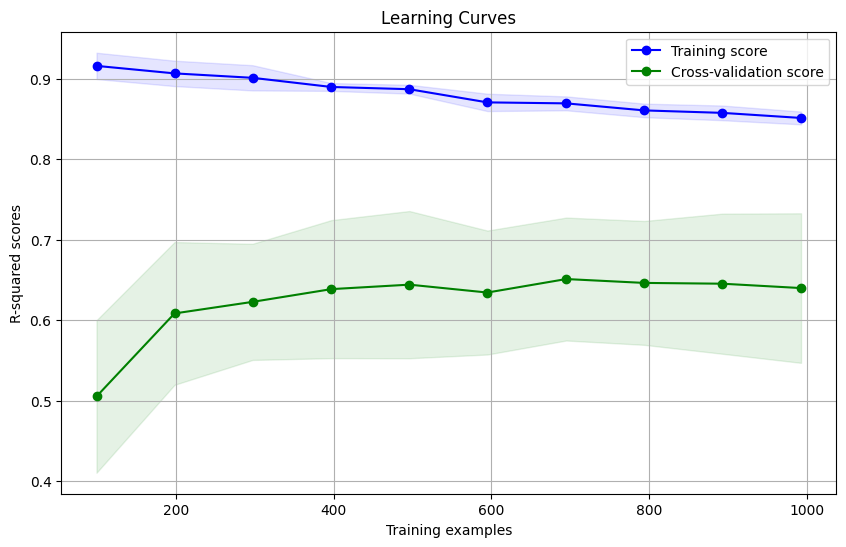

In [19]:
model5 = RandomForestRegressor(max_depth = 6)

plot_learning_curves(model5, X_train, y_train)

We see similar trend like we saw in Model-4 but now the model is has improved as we can see from the cross-validation score which hovers around 65% as compared to 55% in model4. 

In [20]:
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.1565917995133579
Mean Squared Error: 3.3286476430639125
R-squared: 0.5688465310249957


Modeling a XGBoost for the data

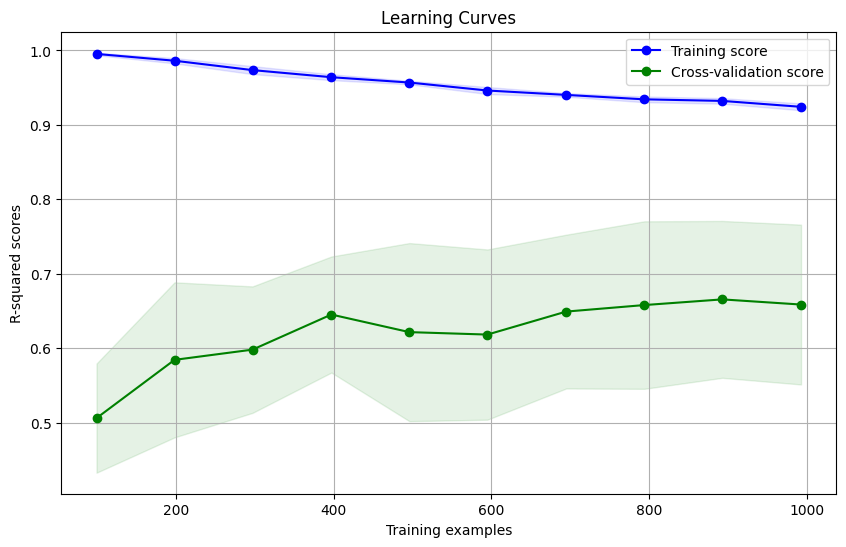

In [21]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "loss": "squared_error",
}

model6 = ensemble.GradientBoostingRegressor(**params)
plot_learning_curves(model6, X_train, y_train)

We further tuned the parameters from max_depth = 6 to 4 and n_estimators = 500 to 100 to reduce overfitting and we saw better performance as well. 

In [22]:
model6.fit(X_train, y_train)
y_pred = model6.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.078812110808209
Mean Squared Error: 2.9234497634199714
R-squared: 0.6213310503143349


Now lets compare all the models that we can created and choose the best one. Given that this is tabular data, I have decided to not model Dense Neural Networks even though we could get better or in-par performance since based on research it is said that for tabular data, the gain isnt that significant for the amount of computation resources a DNN might consume.

Based on the 6 models we have created, model6 i.e XGBoost performs the best. So we shall fo forward with using model-6. 

Lets now explore removing some attributes that we think might not be contributing to the "Final price" 

In [23]:
X_train_filtered = X_train.drop(columns=["Floor"])
X_test_filtered = X_test.drop(columns=["Floor"])


params = {
    "n_estimators": 100,
    "max_depth": 4,
    "loss": "squared_error",
}

model7 = ensemble.GradientBoostingRegressor(**params)

model7.fit(X_train_filtered, y_train)
y_pred = model7.predict(X_test_filtered)


mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0798969082926808
Mean Squared Error: 2.7154082581377077
R-squared: 0.6482782752271724


Living_area and Municipality does play a very important role in the model as the performace drastically reduces when we removed them which reaffirms our insights we did in the EDA phase. 

Upon analyizing the other attributes, removing "Floor" improves the model a bit so we shall ignore it. While for "Lift" and "Balcony" , the performance reduces slightly so we shall keep it. 

So our final model is an XGBoost model. We see an R^2 score of around 65% which suggests that there are other attrributes apart from the ones that we have that contribute to the predictor variable, this could be amount of times the property has been sold before, furnished or not furnished, number of renovations done, parking, natural hazard prone area, tax etc. which can help improve this model. Additionally, given the small dataset that we were only able to extract from the "Hemnet" website, supplying more data to this model can help make the model learn more and perform better. 

We shall now proceed with the next phase which is related to deployment. 

In [24]:
file_path = "encoding_dict.pkl"

with open(file_path, "wb") as f:
    pickle.dump(encoding_dict, f)

In [25]:
pickle.dump(model7,open("model.pkl","wb"))